# Sistema de detecção e classificação de faces

In [ ]:
# Instalar DeepFace
%pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s eta 0:00:00


In [2]:
# Importar bibliotecas
import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from google.colab.patches import cv2_imshow
from deepface import DeepFace

25-09-14 23:03:16 - Directory /root/.deepface has been created
25-09-14 23:03:16 - Directory /root/.deepface/weights has been created


## Imagens

In [3]:
# imagens do pc
from google.colab import files
uploaded = files.upload()

In [4]:
# Função para baixar imagem de uma URL
def get_image_from_url(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200 or 'image' not in response.headers.get('content-type', ''):
            raise ValueError("URL inválida ou não é imagem.")
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((int(img.width * 0.5), int(img.height * 0.5)))  # Redução de tamanho
        return img
    except Exception as e:
        print(f"Erro ao baixar imagem: {e}")
        return None

In [5]:
#  OpenCV trabalha com BGR, enquanto PIL usa RGB.
# Converte imagem PIL para OpenCV
def pil_to_opencv(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

### Escolhendo as imagens

Para esse teste foram escolhidas imagens dos atores do filme brasileiro "Ainda Estou Aqui"

In [6]:
# URLs das imagens (imagem de teste primeiro, depois rostos de referência)
image_urls = [
    "https://p2.trrsf.com/image/fget/cf/940/0/images.terra.com/2024/09/01/1859756416-ainda-estou-aqui.jpg",
    "https://f.i.uol.com.br/fotografia/2025/03/02/174096001767c4f111e0f39_1740960017_3x2_rt.jpg",
    "https://f001.backblazeb2.com/file/sul21site/wp-content/uploads/2025/01/1233810808-abre-perfil-brasil-13-1-450x300.webp",
    "https://image.tmdb.org/t/p/w235_and_h235_face/rPlOdnzqSPkA6UD3IShRtlK8DT8.jpg",
    "https://media.hugogloss.uol.com.br/uploads/2025/02/ator-mirim-de-ainda-estou-aqui--768x432.png"
]

names = ["Selton", "Fernanda", "Cora", "Guilherme"]

## Carregar e codificar rostos conhecidos

* Recebe uma lista de imagens e os nomes correspondentes.

* Converte cada imagem de referência para OpenCV.

* Retorna uma lista de dicionários {imagem, nome}.

In [7]:
# Carrega rostos conhecidos
def load_known_faces(images, names):
    known_faces = []
    for image, name in zip(images, names):
        if image is None:
            print(f"Imagem de {name} não carregada, pulando...")
            continue
        known_faces.append({'image': pil_to_opencv(image), 'name': name})
    return known_faces

* A primeira imagem é o grupo (contém todos os rostos a serem detectados).

* As demais são imagens individuais com os rostos que queremos reconhecer.

In [8]:
# Carregar imagens
all_images = [get_image_from_url(url) for url in image_urls]

# Separar imagem de teste
test_image = all_images[0]
reference_images = all_images[1:]
known_faces = load_known_faces(reference_images, names)

## Exibir a detecção

* Usa o extract_faces() para detectar todos os rostos na imagem de grupo.

* O backend usado é opencv, mas pode ser substituído por retinaface, mtcnn, entre outros.

* Para cada rosto detectado, extraímos as coordenadas (x, y, w, h).

* Recortamos o rosto com ``cropped_face = test_image_cv[y:y+h, x:x+w]``.

* Comparamos esse rosto com cada rosto conhecido usando ``DeepFace.verify``.

O verify retorna:
 * `` {
  "verified": True or False,
  "distance": float,  # quanto menor, mais parecido
  ... } ``

Transformamos a distância em similaridade (%) com:
* `` similarity = (1 - distance) * 100 ``

Detectando rostos na imagem de teste...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5


25-09-14 23:03:33 - 🔗 vgg_face_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5 to /root/.deepface/weights/vgg_face_weights.h5...


100%|██████████| 580M/580M [00:01<00:00, 291MB/s]


Reconhecimento finalizado. Exibindo imagem:


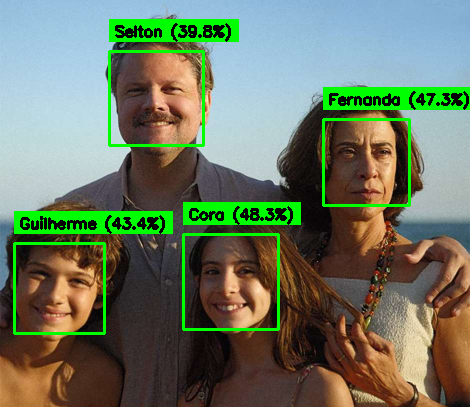

In [9]:
if test_image is None:
    print("Erro ao carregar imagem de teste.")
else:
    test_image_cv = pil_to_opencv(test_image)

    try:
        print("Detectando rostos na imagem de teste...")
        faces = DeepFace.extract_faces(test_image_cv, detector_backend='opencv')
    except Exception as e:
        print(f"Erro na detecção de rostos: {e}")
        faces = []

    for face in faces:
        area = face['facial_area']
        x, y, w, h = area['x'], area['y'], area['w'], area['h']
        cropped_face = test_image_cv[y:y+h, x:x+w]

        best_match = {"name": "Desconhecido", "score": 0}

        for known_face in known_faces:
            try:
                result = DeepFace.verify(
                    cropped_face,
                    known_face['image'],
                    model_name='VGG-Face',
                    enforce_detection=False
                )
                similarity = (1 - result['distance']) * 100  # Percentual de similaridade
                if result['verified'] and similarity > best_match['score']:
                    best_match['name'] = known_face['name']
                    best_match['score'] = similarity
            except Exception as e:
                print(f"Erro ao comparar com {known_face['name']}: {e}")

        # Desenhar retângulo mais estético
        cor = (0, 255, 0)
        espessura = 2
        cv2.rectangle(test_image_cv, (x, y), (x+w, y+h), cor, espessura)

        # Texto com nome e similaridade
        label = f"{best_match['name']} ({best_match['score']:.1f}%)" if best_match['name'] != "Desconhecido" else "Desconhecido"

        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        text_x = x
        text_y = y - 10 if y - 10 > 20 else y + h + 20

        cv2.rectangle(test_image_cv, (text_x, text_y - text_h - 10), (text_x + text_w + 10, text_y), (0, 255, 0), -1)
        cv2.putText(test_image_cv, label, (text_x + 5, text_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    print("Reconhecimento finalizado. Exibindo imagem:")
    cv2_imshow(test_image_cv)
